In [23]:
import re
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')
plt.rcParams['font.size'] = 15

from wordcloud import WordCloud
from nltk import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
import string
from PIL import Image
import PIL.ImageOps
from wordcloud import ImageColorGenerator

STOPWORDS = set(stopwords.words('english'))

from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from keras.layers import Bidirectional
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Embedding
from keras.layers import Flatten
from tensorflow.keras import regularizers

import spacy

from gensim.models import Word2Vec

ModuleNotFoundError: No module named 'gensim'

# Prep Train Data

In [2]:
df_train = pd.read_csv('data/train.csv')
df_test = pd.read_csv('data/test.csv')

In [3]:
df_train = df_train.fillna(' ')
df_train = df_train.fillna(' ')

In [4]:
KEYWORD = 'keyword'
ID = 'id'
LOCATION = 'location'
TEXT = 'text'
TARGET = 'target'
_TEXT_SPACY_OBJ_ = '_TEXT_SPACY_OBJ_'
SENTIMENT = 'sentiment score'
SENTIMENT_ROUND = 'sentiment (rounded off)'
_LOCATION_ = '_location_'
_LOC_POINT = '_loc_point'
_WORDS_PER_TWEET_ = 'words per tweet'
_CHAR_PER_TWEET_ = 'characters per tweet'
_LOC_SPACY_OBJ_ = '_LOC_SPACY_OBJ_'
ALL_TEXT = 'all_text'
ALL_TEXT_JOINED = 'all_text_joined'

In [5]:
def remove_urls(text):
    ''' This method takes in text to remove urls and website links, if any'''
    url_pattern = r'(www.|http[s]?://)(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+'
    text = re.sub(url_pattern, '', text)
    return text

def remove_html_entities(text):
    ''' This method removes html tags'''
    html_entities = r'<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});'
    text = re.sub(html_entities, '', text)
    return text

def remove_social_media_tags(text):
    ''' This method removes @ and # tags'''
    tag_pattern = r'@([a-z0-9]+)|#'
    text = re.sub(tag_pattern, '', text)
    return text

In [6]:
df_train[TEXT] = df_train[TEXT].apply(lambda x : remove_urls(x))
df_train[TEXT] = df_train[TEXT].apply(lambda x : remove_html_entities(x))
df_train[TEXT] = df_train[TEXT].apply(lambda x : remove_social_media_tags(x))

In [7]:
nlp = spacy.load('en_core_web_sm')

def check_location(spacy_loc):
    ''' This method checks if the tweet location has any actual location 
    and saves them as as space-separated value if more than one.
    If no location is found, then save blank'''
    num_loc_in_tweet = len([ent.label_ for ent in spacy_loc.ents if ent.label_ == 'GPE'])
    if num_loc_in_tweet:
        locs_in_tweet = [ent.text for ent in spacy_loc.ents if ent.label_ == 'GPE']
    else:
        return ''
    return ' '.join(locs_in_tweet)

df_train[LOCATION].fillna('', inplace=True)
df_train[_LOC_SPACY_OBJ_] = df_train[LOCATION].apply(nlp)
df_train[_LOC_SPACY_OBJ_] = df_train[_LOC_SPACY_OBJ_].apply(check_location)

In [8]:
df_train.head()

,id,keyword,location,text,target,_LOC_SPACY_OBJ_
0,1,,,Our Deeds are the Reason of this earthquake Ma...,1,
1,4,,,Forest fire near La Ronge Sask. Canada,1,
2,5,,,All residents asked to 'shelter in place' are ...,1,
3,6,,,"13,000 people receive wildfires evacuation ord...",1,
4,7,,,Just got sent this photo from Ruby Alaska as s...,1,


In [9]:
df_train[ALL_TEXT] = df_train[_LOC_SPACY_OBJ_] + df_train[TEXT]
df_train.head()

,id,keyword,location,text,target,_LOC_SPACY_OBJ_,all_text
0,1,,,Our Deeds are the Reason of this earthquake Ma...,1,,Our Deeds are the Reason of this earthquake Ma...
1,4,,,Forest fire near La Ronge Sask. Canada,1,,Forest fire near La Ronge Sask. Canada
2,5,,,All residents asked to 'shelter in place' are ...,1,,All residents asked to 'shelter in place' are ...
3,6,,,"13,000 people receive wildfires evacuation ord...",1,,"13,000 people receive wildfires evacuation ord..."
4,7,,,Just got sent this photo from Ruby Alaska as s...,1,,Just got sent this photo from Ruby Alaska as s...


In [10]:
df_train[df_train[ID] == 48]

,id,keyword,location,text,target,_LOC_SPACY_OBJ_,all_text
31,48,ablaze,Birmingham,Wholesale Markets ablaze,1,Birmingham,Birmingham Wholesale Markets ablaze


In [11]:
tokenizer = Tokenizer(oov_token = "<OOV>", num_words=6000)
tokenizer.fit_on_texts(df_train[ALL_TEXT])
target = df_train[TARGET].values

In [12]:
MAX_LEN = 20
VOCAB_SIZE = 6000

sequences_train = tokenizer.texts_to_sequences(df_train[ALL_TEXT])

padded_train = pad_sequences(sequences_train, padding = 'post', maxlen=MAX_LEN)

In [13]:
X_train, X_test, y_train, y_test = train_test_split(padded_train, target, test_size=0.2)

# Keras Model

In [20]:
best_model_file_name = "models/best_model_simple_LSTM.hdf5"
def get_simple_LSTM_model():
    model = Sequential()
    model.add(Embedding(VOCAB_SIZE, 10, input_length=MAX_LEN))
    model.add(Dropout(0.3))
    model.add(LSTM(100))
    model.add(Dropout(0.3))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(1, activation='sigmoid'))
    return model

callbacks=[
    keras.callbacks.EarlyStopping(monitor="val_loss", 
                                  patience=5, 
                                  verbose=1, 
                                  mode="min", 
                                  restore_best_weights=True),
    keras.callbacks.ModelCheckpoint(filepath=best_model_file_name, 
                                    verbose=1, 
                                    save_best_only=True)
]

model = get_simple_LSTM_model()
print(model.summary())

model.compile(loss='binary_crossentropy',optimizer='adam', metrics=[tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

history = model.fit(X_train, 
                    y_train, 
                    epochs=10, 
                    validation_data=(X_test, y_test), 
                    callbacks=callbacks)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 20, 10)            60000     
_________________________________________________________________
dropout_3 (Dropout)          (None, 20, 10)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               44400     
_________________________________________________________________
dropout_4 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                6464      
_________________________________________________________________
dropout_5 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                

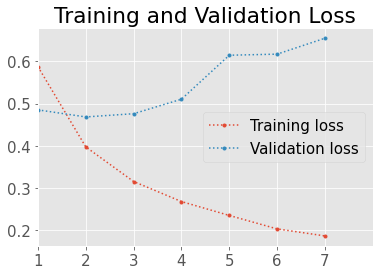

In [21]:
metric_to_plot = "loss"
plt.plot(range(1, max(history.epoch) + 2), history.history[metric_to_plot], ".:", label="Training loss")
plt.plot(range(1, max(history.epoch) + 2), history.history["val_" + metric_to_plot], ".:", label="Validation loss")
plt.title('Training and Validation Loss')
plt.xlim([1,max(history.epoch) + 2])
plt.xticks(range(1, max(history.epoch) + 2))
plt.legend()
plt.show()

In [22]:
# model = keras.models.load_model(best_model_file_name)
y_pred = (model.predict(X_test) > 0.5).astype("int32")
print('Accuracy: ', accuracy_score(y_test, y_pred))
print('Precision: ', precision_score(y_test, y_pred))
print('Recall: ', recall_score(y_test, y_pred))
print('F1 Score: ', f1_score(y_test, y_pred))

Accuracy:  0.7957977675640184
Precision:  0.8066202090592335
Recall:  0.698340874811463
F1 Score:  0.7485852869846403


# Prep Test Data

In [17]:
df_test[TEXT] = df_test[TEXT].apply(lambda x : remove_urls(x))
df_test[TEXT] = df_test[TEXT].apply(lambda x : remove_html_entities(x))
df_test[TEXT] = df_test[TEXT].apply(lambda x : remove_social_media_tags(x))

df_test[LOCATION].fillna('', inplace=True)
df_test[_LOC_SPACY_OBJ_] = df_test[LOCATION].apply(nlp)
df_test[_LOC_SPACY_OBJ_] = df_test[_LOC_SPACY_OBJ_].apply(check_location)

df_test[ALL_TEXT] = df_test[_LOC_SPACY_OBJ_] + df_test[TEXT]

sequences_test = tokenizer.texts_to_sequences(df_test[ALL_TEXT])
padded_test = pad_sequences(sequences_test, padding = 'post', maxlen=MAX_LEN)